In [1]:
import torch
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from GroundingDINO.groundingdino.models import build_model
from PIL import Image
from segment_anything import build_sam, SamPredictor 
from GroundingDINO.groundingdino.util import box_ops
import numpy as np

def load_model_local(config_path, model_path, device='cpu'):
    # Load configuration
    args = SLConfig.fromfile(config_path)
    args.device = device
    # Load model state dictionary
    checkpoint = torch.load(model_path, map_location=device)
    # Build model
    model = build_model(args)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(model_path, log))    
    # Set model to evaluation mode
    _ = model.eval()
    return model

def get_masks(BOX_TRESHOLD,TEXT_TRESHOLD,image_src,sam_checkpoint):
    image_source, image = load_image(image_src)

    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
    )
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

    
    sam = build_sam(checkpoint=sam_checkpoint)
    sam.to(device=device)
    sam_predictor = SamPredictor(sam)
    # set image
    sam_predictor.set_image(image_source)

    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
    masks, _, _ = sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
            )
    return masks


/home/shizijie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "./ShilongLiu/GroundingDINO/groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "./ShilongLiu/GroundingDINO/GroundingDINO_SwinB.cfg.py"
sam_checkpoint = './SAM/sam_vit_h_4b8939.pth'

torch.cuda.set_device(1)
device = torch.device("cuda")
groundingdino_model = load_model_local(ckpt_config_filename, ckpt_filenmae,device=device)

/home/shizijie/.local/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: /home/shizijie/experiment/Grounded-Segment-Anything-main/bert-base-uncased
Model loaded from ./ShilongLiu/GroundingDINO/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/shizijie/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/shizijie/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/shizijie/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


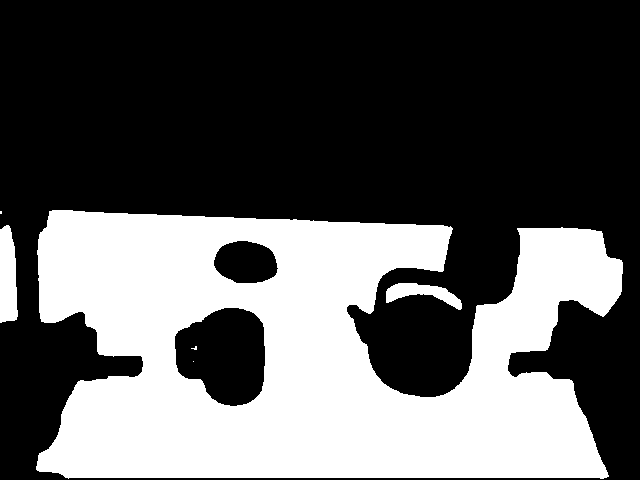

In [3]:
image_src = './test_img/input_img/example/faceImg/face000000.jpg'
TEXT_PROMPT = "tablecloth."

BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

masks = get_masks(BOX_TRESHOLD,TEXT_TRESHOLD,image_src,sam_checkpoint)
image_mask = masks[0][0].cpu().numpy()
image_mask = Image.fromarray(image_mask)
image_mask

In [4]:
import torch
from diffusers import ControlNetModel,StableDiffusionControlNetInpaintPipeline
from PIL import Image
torch.cuda.set_device(1)
controlnet = ControlNetModel.from_pretrained(
    "./control_v11p_sd15_inpaint", torch_dtype=torch.float32
).to("cuda")

pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "./stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float32
).to("cuda")
image_source = Image.open('./test_img/input_img/table_cloth/Stainless steel material, smooth texture, desktop.jpg').resize((1280,960))
image_source = image_source.convert("RGB")

/home/shizijie/.local/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 29.66it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
mask = Image.new("L",image_source.size,color=0).convert('1')
import random
x = random.randint(10,100)
y = random.randint(700,750)
side = 200
for i in range(x,x+side):
    for j in range(y,y+side):
        mask.putpixel((i,j),255)
print(x,y)

67 710


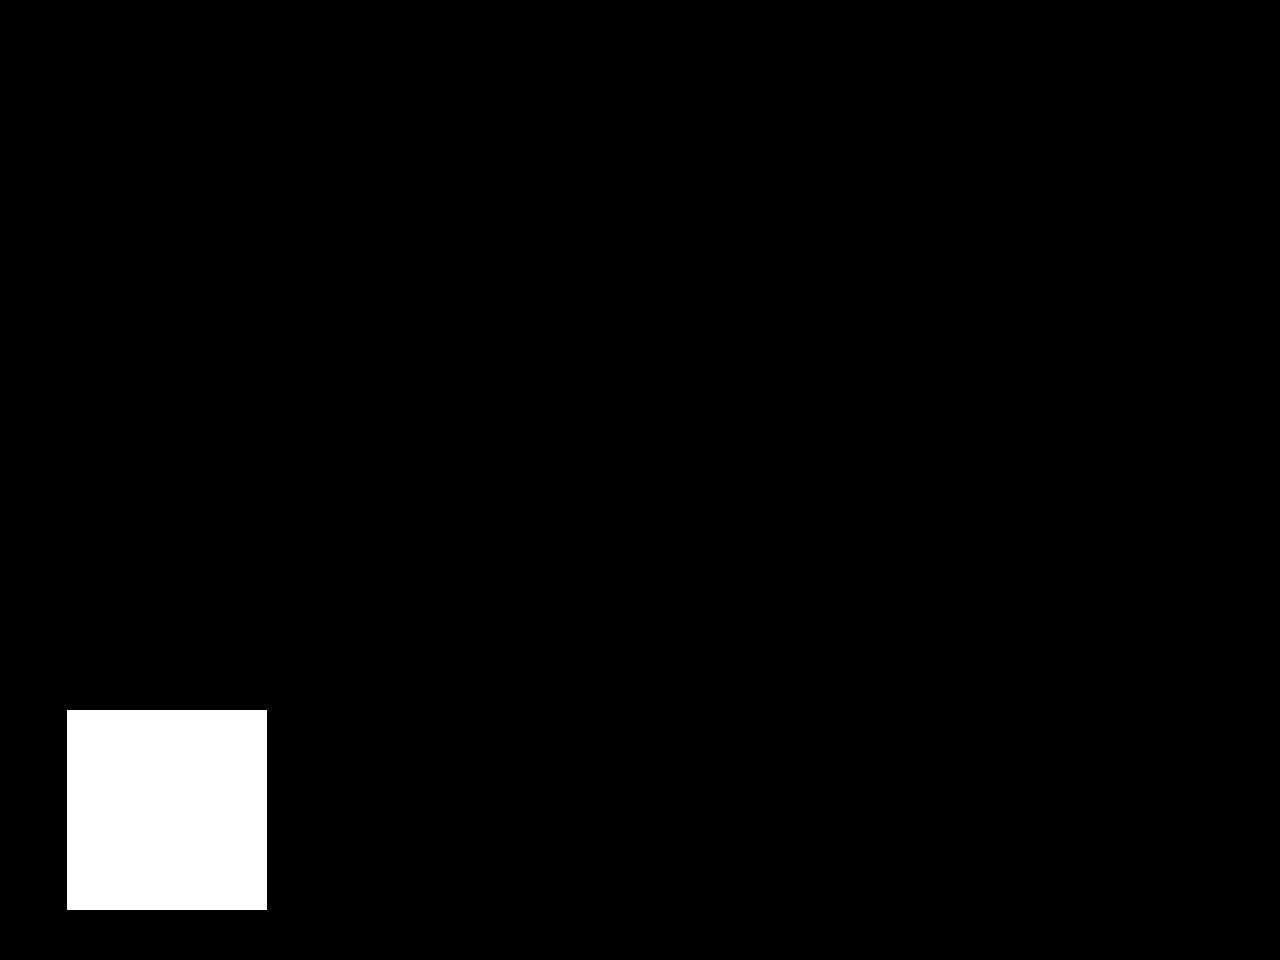

In [6]:
import numpy as np
def make_inpaint_condition_replace(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

control_image = make_inpaint_condition_replace(image_source, mask)
mask

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:52<00:00,  1.16it/s]


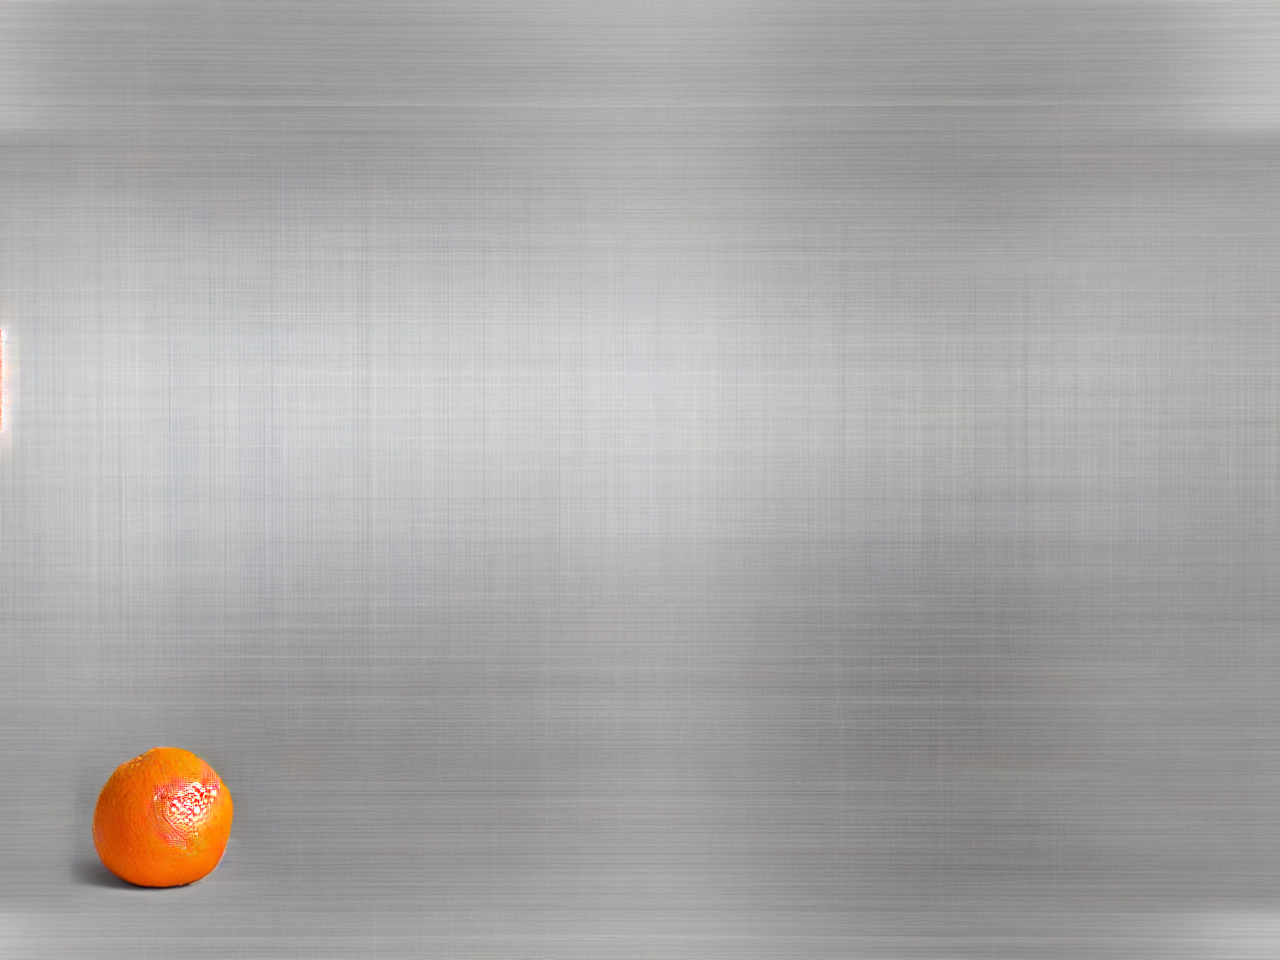

In [7]:
prompt = "orange,one,fresh fruit,three-dimensional,total"
# prompt = "bottle, plastic, blue pattern,real,total"
generator = torch.Generator("cuda").manual_seed(1)
image_add = pipe_control(   
                        prompt=prompt, 
                        generator=generator,
                        guidance_scale=10,
                        strength=1,
                        eta = 1,
                        image=image_source,
                        control_image=control_image,
                        mask_image=mask,
                        num_inference_steps=200).images[0]
image_add

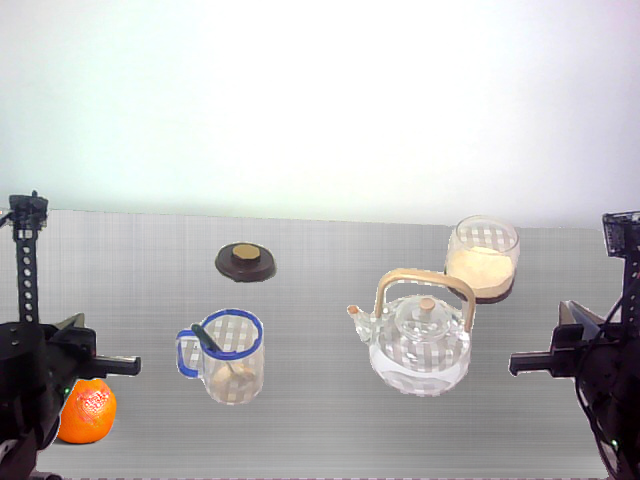

In [8]:
image_ori = Image.open(image_src)
image_ori = image_ori.resize(image_mask.size)
image_add = image_add.resize(image_mask.size)

# 创建一个空白图像
result_image = Image.new("RGB", image_mask.size)
# 将图像按照黑色部分进行拼合
for x in range(image_mask.width):
    for y in range(image_mask.height):
        ratio = (255 - image_mask.getpixel((x, y))) / 255.0  
        color_b = image_ori.getpixel((x, y))
        color_c = image_add.getpixel((x, y))
        blended_color = (
            int(color_b[0] * ratio + color_c[0] * (1 - ratio)),
            int(color_b[1] * ratio + color_c[1] * (1 - ratio)),
            int(color_b[2] * ratio + color_c[2] * (1 - ratio))
        )
        result_image.putpixel((x, y), blended_color)

result_image